# Generate a curve artwork by using GAN

In [1]:
import sys
# !python --version
# !python3 --version
# !{sys.executable} --version
# !{sys.executable} -m pip install torch
# !{sys.executable} -m pip install torchsummary
# !{sys.executable} -m pip install tqdm
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchsummary import summary
import ipywidgets as widgets
from ipywidgets import IntSlider
from IPython.display import clear_output
from ipywidgets.widgets.interaction import show_inline_matplotlib_plots
%matplotlib inline
# from tqdm import tqdm

In [2]:
# hyper parameters
BATCH_SIZE = 64
LR_G = .0001
LR_D = .0001
N_IDEAS = 5 # input size
ART_COMPONENTS = 20 # output size
PAINT_POINTS = np.vstack([np.linspace(-1, 1, ART_COMPONENTS) for _ in range(BATCH_SIZE)])
TOTAL_STEPS = 10000
SHOW_INTERVAL = TOTAL_STEPS / 100

In [3]:
def artist_works():
    # artwork 1
#     paintings = np.tan(np.tan(PAINT_POINTS * np.pi))
    # artwork 2
#     paintings = np.sin(np.exp(PAINT_POINTS*2))**2
    # artwork 3
    paintings = np.sin(PAINT_POINTS*np.pi)
    # artwork 4
#     paintings = np.exp(PAINT_POINTS*np.pi)
    # artwork 5
#     paintings = np.arccos(np.sin(PAINT_POINTS*np.e)) + np.sin(np.cos(PAINT_POINTS*np.pi))
    r = .05 * np.random.randn(1, ART_COMPONENTS)
    paintings += r
    paintings = torch.from_numpy(paintings).float()
    return paintings

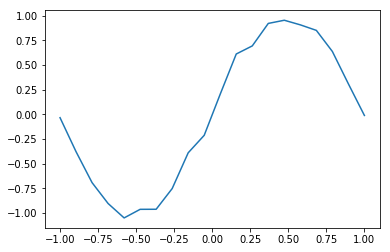

In [4]:
# show one of the paintings
plt.plot(PAINT_POINTS[0], artist_works()[0])
plt.show()

In [5]:
G = nn.Sequential(
    nn.Linear(N_IDEAS, 128),
    nn.ReLU(),
    nn.Linear(128, ART_COMPONENTS),
)

D = nn.Sequential(
    nn.Linear(ART_COMPONENTS, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid(),
)

In [6]:
summary(G, (1, N_IDEAS))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]             768
              ReLU-2               [-1, 1, 128]               0
            Linear-3                [-1, 1, 20]           2,580
Total params: 3,348
Trainable params: 3,348
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


In [7]:
summary(D, (1, ART_COMPONENTS))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 128]           2,688
              ReLU-2               [-1, 1, 128]               0
            Linear-3                 [-1, 1, 1]             129
           Sigmoid-4                 [-1, 1, 1]               0
Total params: 2,817
Trainable params: 2,817
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


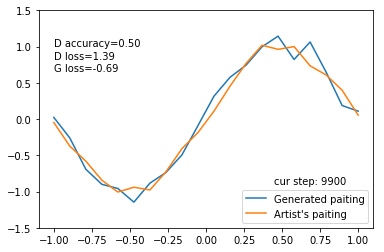

In [8]:
opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)
plt.ion()
D_loss_history = []
G_loss_history = []
for step in range(TOTAL_STEPS):
    artist_paintings = artist_works()
    G_ideas = torch.randn(BATCH_SIZE, N_IDEAS)
    G_paintings = G(G_ideas)
    prob_artist0 = D(artist_paintings)
    prob_artist1 = D(G_paintings)
    D_loss = -torch.mean(torch.log(prob_artist0) + torch.log(1. -prob_artist1))
    G_loss = torch.mean(torch.log(1. -prob_artist1))
    D_loss_history.append(D_loss)
    G_loss_history.append(G_loss)
    opt_D.zero_grad() 
    D_loss.backward(retain_graph=True)
    opt_D.step() # update the network parameters
    opt_G.zero_grad()
    G_loss.backward()
    opt_G.step()
    # plotting
    if step % SHOW_INTERVAL == 0:
        plt.cla()
        plt.plot(PAINT_POINTS[0], G_paintings.data.numpy()[0], label='Generated paiting')
        plt.plot(PAINT_POINTS[0], artist_paintings[0], label='Artist\'s paiting')
        plt.text(-1, 1, 'D accuracy=%.2f' % prob_artist0.data.numpy().mean())
        plt.text(-1, .83, 'D loss=%.2f' % D_loss.data.numpy())
        plt.text(-1, .66, 'G loss=%.2f' % G_loss.data.numpy())
        plt.ylim((-1.5, 1.5))
        plt.text(.45, -.9, 'cur step: %d' % step)
        plt.legend(loc='lower right')
        clear_output(wait=True)
        plt.show()
plt.ioff()
plt.show()

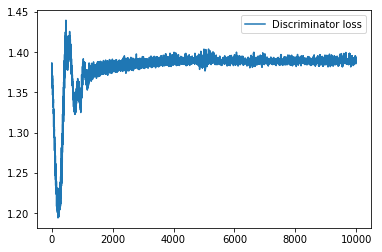

In [9]:
# discriminator loss
plt.plot(D_loss_history, label='Discriminator loss')
plt.legend(loc='best')
plt.show()

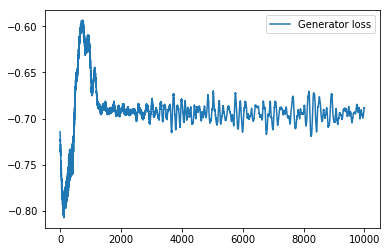

In [10]:
# generator loss
plt.plot(G_loss_history, label='Generator loss')
plt.legend(loc='best')
plt.show()

In [11]:
# define the slider
def slider(value, ideas_, idx, model):
    int_range = widgets.FloatSlider(continuous_update=False,
    min=-10, max=10, value=value)
    output = widgets.Output()
    display(int_range, output)
    def on_value_change(change):
        with output:
            clear_output(wait=True)
            ideas_[idx] = change['new']
            ideas_tensor = torch.from_numpy(ideas_)
            res = model(ideas_tensor)
            plt.plot(res.data.numpy())
            show_inline_matplotlib_plots()
    int_range.observe(on_value_change, names='value')

In [12]:
# test generator
ideas = np.random.randn(5).astype(np.float32)
for i, x in enumerate(ideas):
    slider(x, ideas, i, G)

FloatSlider(value=-1.3798211812973022, continuous_update=False, max=10.0, min=-10.0)

Output()

FloatSlider(value=-1.3480135202407837, continuous_update=False, max=10.0, min=-10.0)

Output()

FloatSlider(value=1.2908846139907837, continuous_update=False, max=10.0, min=-10.0)

Output()

FloatSlider(value=-1.0433149337768555, continuous_update=False, max=10.0, min=-10.0)

Output()

FloatSlider(value=0.6915717124938965, continuous_update=False, max=10.0, min=-10.0)

Output()